This code has very kindly been shared by Xinyi 

# PSD in CASIM

The hydrometeor particle size distribution (PSD) is represented by (Field, et al., 2023):

$$\mathcal{N}(D)=n_x\frac{\lambda_{x}^{1+\mu_x}}{\Gamma(1+\mu_x)}D^{\mu_x}e^{-\lambda D}$$


$D$: particle diameter (m)

$n_x$: the number concentration for the hydrometeor (graupel in this case) (m-3)

$\lambda_x$: the slope parameter that evolves as mass and number change (needs calculation)

$\mu_x$: fixed shape parameter for each type of hydrometeor


## Calculation of $\lambda_x$

Given the definition of the PSD as above, we define the $p\text{th}$ moment of the distribution as


$$M(p) \equiv \int_0^\infty D^{p}\mathcal{N}(D)d(D)=\frac{n_x}{\lambda^{p}}
\frac{\Gamma(1+\mu_x+p)}{\Gamma(1+\mu_x)}$$


For mass of a hydrometeor in CASIM, it is given a mass-diameter relationship:
$$m_x(D)=aD^{b}$$

where $a$ and $b$ are predefined for each hydrometeor (a is 500 $\pi$/6 and b is 3 for graupel). 


The 3rd moment is

$$
    M(3)=\int_0^\infty D^{3}\mathcal{N}(D)d(D)
    =\frac{n_x}{\lambda^{3}}\frac{\Gamma(1+\mu_x+3)}{\Gamma(1+\mu_x)}
    =\frac{mass}{a}
$$
- $d$ relates to the Mass-dimension constant in table A1?
<br>
Thus we can calculate $\lambda$ with

$$\lambda = (a\frac{n_x}{mass}
\frac{\Gamma(1+\mu+3)}{\Gamma(1+\mu)})
^{\frac{1}{3}}
$$


## Cumulative distribution function of the gamma distribution

The cumulative distribution function at D is

$$F(D)=\frac{\gamma(1+\mu_x,\lambda D)}{\Gamma(a)}$$

where $\gamma(s,x)$ is the lower incomplete gamma function

Some useful links:

https://statproofbook.github.io/P/gam-cdf.html
<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html
<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gdtr.html#scipy.special.gdtr

#### just some notes when chatting to Xinyi
SciPy functions also have parameters a and b, like CASIM distribution, but describe different things.
<br>
likewise, $\mu$ is often defined differently -> $z$-1, so we need to do $\mu$ +1 for it to work correctly
<br>
with fixed $\mu$, we only need to calculate $\lambda$ !!
<br>
(i have forgotten what a moment is) i though just number / mass / reflectivity was the moment - but here for the mass, this is the 3rd moment?
<br>
`partial_integral_gamma` is probably easiest to use
<br>
this calculation should be done per grid box?

In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import iris

from scipy.special import gamma
from scipy.special import gammainc, gammaincc, gdtr

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

font = {'size'   : 16}
plt.rc('font', **font)

In [12]:
import sys
print(sys.executable)

/opt/jaspy/bin/python


In [13]:
### Function for model gamma function in (m-3 m-1)
# x = diameter, n = number conc, mu = mu, lambda = lambda (needs calculating)
def model_gamma_pdf(x,n,mu,lamda):
    n0 = (n) * (lamda**(1+mu)) / (gamma(1+mu)) # directly pulled from field paper - (A2)
    N = n0 * (x**mu) * (np.exp(-lamda*x)) 
    return N

### Function for using scipy.special.gdtr to calculate the gamma distribution cumulative distribution function
### I don't like this because in the gdtr you have to switch the order of mu and lambda :(
def model_gamma_cdf(x,n,mu,lam):
    return n*gdtr(lam,1+mu,x)

### Function for integral over the lower and upper limits of the gamma PDF
def partial_integral_gamma(n,mu,lam,lower,upper):
    lower_inc = gammainc(1+mu,lam*lower)
    upper_inc = gammainc(1+mu,lam*upper)
    return n*(upper_inc-lower_inc)

## Function for calculating lamda from mass and number
## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
def calc_lambda(model_mass,model_num,hydro):
    # Read in gamma PDF values (Field et al., 2023, Table 1)
    mu = hydroparameters[hydro][0]
    c = hydroparameters[hydro][1]
    d = hydroparameters[hydro][2]
    
    gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
    nm_ratio = model_num / model_mass
    if d == 2:
        lam = np.sqrt(c*nm_ratio*gamma_ratio)
    elif d == 3:
        lam = np.cbrt(c*nm_ratio*gamma_ratio)
    else:
        print("Woohoo, something is wrong here for the moment value!")
        lam = np.nan
    return lam

In [14]:
### Ditionary contains mu, mass-dimention (a,b)
hydroparameters = {'liquid':[2.5,522,3],
                   'rain':[2.5,522,3],
                   'ice':[2.5,np.pi*200/6,3],
                   'snow':[2,0.026,2],
                   'graupel':[2.5,np.pi*500/6,3]}

In [15]:
hydro='liquid'
n = 120e6 # m-3
m = 0.0003 # kg m-3
mu = hydroparameters[hydro][0]
lam = calc_lambda(m,n,hydro)
print(mu,lam)

2.5 262497.1428260441


110.03303061775871
110.0330306177587


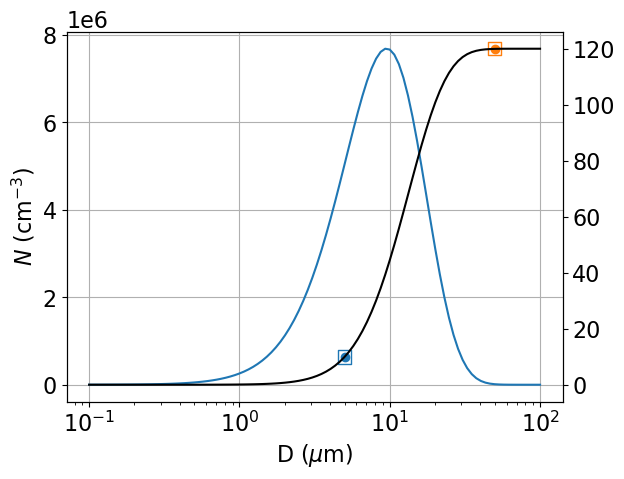

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

powers = np.linspace(-7,-4,100)
bins   = 10**powers

ax1.plot(bins*1e6,
         model_gamma_pdf(bins,n,mu,lam)/1e6)
ax1.grid(True)

ax2.plot(bins*1e6,
         model_gamma_cdf(bins,n,mu,lam)/1e6,
         color='k')

## Just to check that they are the same
ax2.scatter(5,n*gammainc(1+mu,lam*5e-6)/1e6)
ax2.scatter(5,model_gamma_cdf(5e-6,n,mu,lam)/1e6,
            marker='s',facecolor='none',edgecolor='C0',
            s=90)

ax2.scatter(50,n*gammainc(1+mu,lam*50e-6)/1e6)
ax2.scatter(50,model_gamma_cdf(50e-6,n,mu,lam)/1e6,
            marker='s',facecolor='none',edgecolor='C1',
            s=90)

# doing it both ways to show it is the same
print(partial_integral_gamma(n,mu,lam,5e-6,50e-6)/1e6) # total number conc per cm-3
print((model_gamma_cdf(50e-6,n,mu,lam) - model_gamma_cdf(5e-6,n,mu,lam))/1e6)

ax1.set_ylabel('$N$ (cm$^\mathrm{-3}$)')
ax1.set_xlabel('D ($\mu$m)')
# ax1.set_yscale('log')
ax1.set_xscale('log')

In [2]:
nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
file_density = '20220730T0000Z_LMagda_km1p5set1_expt1_pz016_density.nc'
file_number = '20220730T0000Z_LMagda_km1p5set1_expt1_pz016.nc'

In [3]:
ds_hydro = xr.load_dataset(nc_file_loc + file_number)
ds_denst = xr.load_dataset(nc_file_loc + file_density)

da_gmass = ds_hydro['mass_fraction_of_graupel_in_air'][0,:,:,:]
da_gnum  = ds_hydro['number_of_graupel_particles_per_kg_of_air'][0,:,:,:]
da_aden  = ds_denst['Density used for rad layers (kg m-3)'][0,:,:,:]

## Unit conversion
gmass = da_gmass / da_aden
gnum  = da_gnum / da_aden

print(np.nanmedian(gmass.data[gmass.data>=1e-5]))
print(np.nanmedian(gnum.data[gmass.data>=1e-5]))

1.0427595e-05
2021.1084


In [4]:
gmass

<xarray.DataArray (model_level_number: 70, grid_latitude: 300,
                   grid_longitude: 300)> Size: 25MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(70, 300, 300), dtype=float32)
Coordinates:
  * model_level_number       (model_level_number) int32 280B 1 2 3 ... 68 69 70
  * grid_latitude            (grid_latitude) float32 1kB -2.025 -2.012 ... 2.011
  * grid_longitude           (grid_longitude) float64 2kB 358.0 358.0 ... 362.0
    forecast_reference_time  datetime64[ns] 8B 2022-07-30
    level_height             (model_level_number) float32 280B 5.0 ... 4e+04
    sigma                    (model_level_number) float32 280B 0.9994 ... 0.0
    lon                      (grid_latitude, grid_longitude) float64 720kB -1...
    lat                      (grid_latitude, grid_longitude) float64 720kB 31...

In [8]:
ds_hydro['mass_fraction_of_graupel_in_air'].max()

<xarray.DataArray 'mass_fraction_of_graupel_in_air' ()> Size: 4B
array(0.00243966, dtype=float32)
Coordinates:
    forecast_reference_time  datetime64[ns] 8B 2022-07-30

In [19]:
hydro = 'graupel'
n = np.nanmedian(gnum.data[gmass.data>=1e-5]) # m-3
m = np.nanmedian(gmass.data[gmass.data>=1e-5]) # kg m-3
mu = hydroparameters[hydro][0]
lam = calc_lambda(m,n,hydro)
print(mu,lam)

2.5 16380.950492416207


1.734721773363908
1.734721773363908


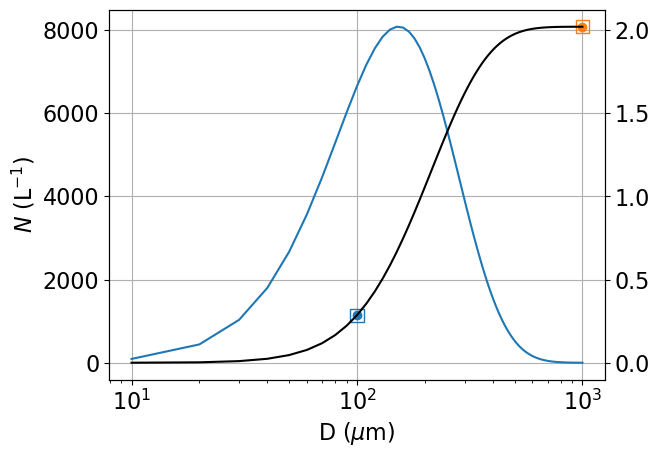

In [195]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

bins = np.arange(10,1010,10)*1e-6

ax1.plot(bins*1e6,
         model_gamma_pdf(bins,n,mu,lam)/1e3)
ax1.grid(True)

ax2.plot(bins*1e6,
         model_gamma_cdf(bins,n,mu,lam)/1e3,
         color='k')

## Just to check that they are the same
ax2.scatter(100,n*gammainc(1+mu,lam*100e-6)/1e3)
ax2.scatter(100,model_gamma_cdf(100e-6,n,mu,lam)/1e3,
            marker='s',facecolor='none',edgecolor='C0',
            s=90)

ax2.scatter(1000,n*gammainc(1+mu,lam*1000e-6)/1e3)
ax2.scatter(1000,model_gamma_cdf(1000e-6,n,mu,lam)/1e3,
            marker='s',facecolor='none',edgecolor='C1',
            s=90)

print(partial_integral_gamma(n,mu,lam,100e-6,1000e-6)/1e3)
print((model_gamma_cdf(1000e-6,n,mu,lam) - model_gamma_cdf(100e-6,n,mu,lam))/1e3)

ax1.set_ylabel('$N$ (L$^\mathrm{-1}$)')
ax1.set_xlabel('D ($\mu$m)')
# ax1.set_yscale('log')
ax1.set_xscale('log')